# Aggregate Accuracy Motion Network

    The idea here to actually sum up the softmax scores for several frames for a single class rather than sinply use a single  frame. The hope is that there are several similarities between frames so what you would have is for a another class that  scores closely you would expect a chance that its intermediate frame discounts its aggregate score compared to the actual class. This would lead to a higher than expect aggregate score 

In [1]:
import os
import sys


up1 = os.path.abspath('../utils/') 
up2 = os.path.abspath('../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:


from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
import cv2

import os, os.path
import random


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [5]:

default_validation_options = { 'rescale' : 1./255, \
                         'samplewise_center': True, \
                         'samplewise_std_normalization':True \
    }

class DataGenerator(keras.utils.Sequence):
    'Generate UCF 101 data for keras'
    def __init__(self, list_IDs, labels, data_dir, batch_size=64, dim=(224,224), num_frames=3, num_rand_transforms=5, \
                 n_classes=101, shuffle=True, return_files=False, validation_opts=default_validation_options):        
        'Initialisation'
        self.data_dir = data_dir
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.num_frames = num_frames
        self.num_rand_transforms = num_rand_transforms
        self.shuffle = shuffle 
        self.n_classes = n_classes
        self.return_files = return_files
        self.on_epoch_end()
        self.data_gen = ImageDataGenerator(**default_validation_options)
    
    def  __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        'Generate one batch of data'
        print(index)
        # find list of ids
        ID = self.list_IDs[index]
        
        # Generate data 
        X, y = self.__data_generation(ID)
        
        return X, y
    
    def __data_generation(self, ID):
        'Generates data containing batch_size samples' 
        X = np.empty((self.num_rand_transforms * self.num_frames, *self.dim, 2), dtype=np.float32)
        y = np.empty((self.num_rand_transforms * self.num_frames), dtype=int)
        
        # Generate data 
        _X = self.__data_load(ID)            
        y[:] = self.labels[ID]-1
            
        for i, img, in enumerate(_X):
            _X[i] = self.data_gen.standardize(_X[i])
        
        # for each frame apply the requisite number of random transformations
        k = 0
        for i in range(self.num_frames):
            for j in range(self.num_rand_transforms):
                X[k,] = self.data_gen.random_transform(_X[i])
                k = k + 1
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def __data_load(self, ID):
        u_file_dir = self.data_dir + "/u/" + ID.rstrip('.avi')
        v_file_dir = self.data_dir + "/v/" + ID.rstrip('.avi')
        n_frames = len([name for name in os.listdir(u_file_dir) if name.endswith('.jpg')])
        frame_range = range(1,n_frames+1,1)
        
        # select num_frames random frames
        
        frames = random.sample(frame_range, self.num_frames)
        images = list()
        for frame in frames:
            u_file = u_file_dir + os.sep + 'frame' + f'{frame:06}' + '.jpg'
            v_file = v_file_dir + os.sep + 'frame' + f'{frame:06}' + '.jpg'
            u_img = cv2.imread(u_file, 0)
            u_img = cv2.resize(u_img, self.dim) 
            u_img = u_img.reshape((*self.dim,1))
            v_img = cv2.imread(v_file, 0)
            v_img = cv2.resize(v_img, self.dim) 
            v_img = v_img.reshape((*self.dim,1))
            images.append(np.concatenate((u_img, v_img), axis=2).astype(float))
        return images
    

In [6]:
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getSimonyanOxfordModel
from keras.optimizers import SGD
from matplotlib import pyplot as plt

In [7]:

validation_options = { 'rescale' : 1./255 }


params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 64,
          'num_frames': 5,
          'num_rand_transforms': 10,
          'shuffle': True, 
               'validation_opts' : validation_options }


In [8]:

id_test = get_test_data_opt_flow('../data/ucf101_splits/testlist01.txt', \
                       '../data/ucf101_splits/classInd.txt')

validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [9]:
X = None
y = None

i = 0

for (_x, _y) in validation_generator:
    X = _x
    y = _y
    if i == 50:        
        break
    i =  i + 1
X.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


(50, 224, 224, 2)

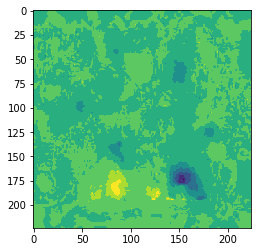

In [10]:
plt.imshow(X[0,:,:,1])

In [11]:
y[0].argmax(axis=0)

1

# Now to calculate soft max scores


In [12]:
model=getSimonyanOxfordModel((224,224,2), n_classes=101, printmod=0)

In [13]:
model.load_weights('../data/weights/motion_model_weights_simonyan_p2.hdf5')

In [16]:
X.shape

(50, 224, 224, 2)

In [17]:
result = model.predict(X)

In [18]:
result.shape

(50, 101)

In [19]:
result_avg = np.average(result, axis=0)

In [20]:
#result_avg.shape
result_avg.argmax(axis=0)

48

In [21]:
result.shape

(50, 101)

In [22]:
len(validation_generator)


3783

In [23]:
i = 0
for (X, y) in validation_generator:
    result = model.predict(X)
    f1 = open('/data/temp/motion_inference_result/result' +  f'{i:06}' +  '.npy' , 'wb')
    f2 = open('/data/temp/motion_inference_result/result_class' + f'{i:06}' + '.npy' , 'wb')
    np.save(f1, result)
    print('y_argmax',  y[0].argmax(axis=0))
    np.save(f2, y)    
    i = i + 1
    if i > 3782:
        break
        

0
y_argmax 0
1
y_argmax 0
2
y_argmax 0
3
y_argmax 0
4
y_argmax 0
5
y_argmax 0
6
y_argmax 0
7
y_argmax 0
8
y_argmax 0
9
y_argmax 0
10
y_argmax 0
11
y_argmax 0
12
y_argmax 0
13
y_argmax 0
14
y_argmax 0
15
y_argmax 0
16
y_argmax 0
17
y_argmax 0
18
y_argmax 0
19
y_argmax 0
20
y_argmax 0
21
y_argmax 0
22
y_argmax 0
23
y_argmax 0
24
y_argmax 0
25
y_argmax 0
26
y_argmax 0
27
y_argmax 0
28
y_argmax 0
29
y_argmax 0
30
y_argmax 0
31
y_argmax 0
32
y_argmax 0
33
y_argmax 0
34
y_argmax 0
35
y_argmax 0
36
y_argmax 0
37
y_argmax 0
38
y_argmax 0
39
y_argmax 0
40
y_argmax 0
41
y_argmax 0
42
y_argmax 0
43
y_argmax 0
44
y_argmax 1
45
y_argmax 1
46
y_argmax 1
47
y_argmax 1
48
y_argmax 1
49
y_argmax 1
50
y_argmax 1
51
y_argmax 1
52
y_argmax 1
53
y_argmax 1
54
y_argmax 1
55
y_argmax 1
56
y_argmax 1
57
y_argmax 1
58
y_argmax 1
59
y_argmax 1
60
y_argmax 1
61
y_argmax 1
62
y_argmax 1
63
y_argmax 1
64
y_argmax 1
65
y_argmax 1
66
y_argmax 1
67
y_argmax 1
68
y_argmax 1
69
y_argmax 1
70
y_argmax 1
71
y_argmax 1
72

y_argmax 14
544
y_argmax 14
545
y_argmax 14
546
y_argmax 14
547
y_argmax 14
548
y_argmax 14
549
y_argmax 14
550
y_argmax 14
551
y_argmax 14
552
y_argmax 14
553
y_argmax 14
554
y_argmax 14
555
y_argmax 14
556
y_argmax 14
557
y_argmax 14
558
y_argmax 14
559
y_argmax 14
560
y_argmax 14
561
y_argmax 14
562
y_argmax 14
563
y_argmax 14
564
y_argmax 14
565
y_argmax 14
566
y_argmax 14
567
y_argmax 14
568
y_argmax 15
569
y_argmax 15
570
y_argmax 15
571
y_argmax 15
572
y_argmax 15
573
y_argmax 15
574
y_argmax 15
575
y_argmax 15
576
y_argmax 15
577
y_argmax 15
578
y_argmax 15
579
y_argmax 15
580
y_argmax 15
581
y_argmax 15
582
y_argmax 15
583
y_argmax 15
584
y_argmax 15
585
y_argmax 15
586
y_argmax 15
587
y_argmax 15
588
y_argmax 15
589
y_argmax 15
590
y_argmax 15
591
y_argmax 15
592
y_argmax 15
593
y_argmax 15
594
y_argmax 15
595
y_argmax 15
596
y_argmax 15
597
y_argmax 15
598
y_argmax 15
599
y_argmax 15
600
y_argmax 15
601
y_argmax 15
602
y_argmax 15
603
y_argmax 15
604
y_argmax 15
605
y_argmax

y_argmax 27
1053
y_argmax 27
1054
y_argmax 27
1055
y_argmax 27
1056
y_argmax 27
1057
y_argmax 27
1058
y_argmax 27
1059
y_argmax 27
1060
y_argmax 27
1061
y_argmax 27
1062
y_argmax 27
1063
y_argmax 27
1064
y_argmax 27
1065
y_argmax 27
1066
y_argmax 27
1067
y_argmax 27
1068
y_argmax 27
1069
y_argmax 27
1070
y_argmax 27
1071
y_argmax 27
1072
y_argmax 27
1073
y_argmax 27
1074
y_argmax 27
1075
y_argmax 28
1076
y_argmax 28
1077
y_argmax 28
1078
y_argmax 28
1079
y_argmax 28
1080
y_argmax 28
1081
y_argmax 28
1082
y_argmax 28
1083
y_argmax 28
1084
y_argmax 28
1085
y_argmax 28
1086
y_argmax 28
1087
y_argmax 28
1088
y_argmax 28
1089
y_argmax 28
1090
y_argmax 28
1091
y_argmax 28
1092
y_argmax 28
1093
y_argmax 28
1094
y_argmax 28
1095
y_argmax 28
1096
y_argmax 28
1097
y_argmax 28
1098
y_argmax 28
1099
y_argmax 28
1100
y_argmax 28
1101
y_argmax 28
1102
y_argmax 28
1103
y_argmax 28
1104
y_argmax 28
1105
y_argmax 28
1106
y_argmax 28
1107
y_argmax 28
1108
y_argmax 28
1109
y_argmax 28
1110
y_argmax 28
11

y_argmax 40
1536
y_argmax 40
1537
y_argmax 40
1538
y_argmax 40
1539
y_argmax 40
1540
y_argmax 40
1541
y_argmax 40
1542
y_argmax 40
1543
y_argmax 40
1544
y_argmax 40
1545
y_argmax 40
1546
y_argmax 40
1547
y_argmax 40
1548
y_argmax 40
1549
y_argmax 40
1550
y_argmax 41
1551
y_argmax 41
1552
y_argmax 41
1553
y_argmax 41
1554
y_argmax 41
1555
y_argmax 41
1556
y_argmax 41
1557
y_argmax 41
1558
y_argmax 41
1559
y_argmax 41
1560
y_argmax 41
1561
y_argmax 41
1562
y_argmax 41
1563
y_argmax 41
1564
y_argmax 41
1565
y_argmax 41
1566
y_argmax 41
1567
y_argmax 41
1568
y_argmax 41
1569
y_argmax 41
1570
y_argmax 41
1571
y_argmax 41
1572
y_argmax 41
1573
y_argmax 41
1574
y_argmax 41
1575
y_argmax 41
1576
y_argmax 41
1577
y_argmax 41
1578
y_argmax 41
1579
y_argmax 41
1580
y_argmax 41
1581
y_argmax 41
1582
y_argmax 41
1583
y_argmax 41
1584
y_argmax 41
1585
y_argmax 41
1586
y_argmax 41
1587
y_argmax 41
1588
y_argmax 41
1589
y_argmax 41
1590
y_argmax 41
1591
y_argmax 41
1592
y_argmax 41
1593
y_argmax 41
15

y_argmax 53
2019
y_argmax 53
2020
y_argmax 53
2021
y_argmax 53
2022
y_argmax 53
2023
y_argmax 53
2024
y_argmax 53
2025
y_argmax 53
2026
y_argmax 53
2027
y_argmax 53
2028
y_argmax 53
2029
y_argmax 53
2030
y_argmax 53
2031
y_argmax 53
2032
y_argmax 53
2033
y_argmax 53
2034
y_argmax 53
2035
y_argmax 53
2036
y_argmax 53
2037
y_argmax 53
2038
y_argmax 53
2039
y_argmax 53
2040
y_argmax 53
2041
y_argmax 53
2042
y_argmax 53
2043
y_argmax 53
2044
y_argmax 53
2045
y_argmax 53
2046
y_argmax 53
2047
y_argmax 53
2048
y_argmax 53
2049
y_argmax 54
2050
y_argmax 54
2051
y_argmax 54
2052
y_argmax 54
2053
y_argmax 54
2054
y_argmax 54
2055
y_argmax 54
2056
y_argmax 54
2057
y_argmax 54
2058
y_argmax 54
2059
y_argmax 54
2060
y_argmax 54
2061
y_argmax 54
2062
y_argmax 54
2063
y_argmax 54
2064
y_argmax 54
2065
y_argmax 54
2066
y_argmax 54
2067
y_argmax 54
2068
y_argmax 54
2069
y_argmax 54
2070
y_argmax 54
2071
y_argmax 54
2072
y_argmax 54
2073
y_argmax 54
2074
y_argmax 54
2075
y_argmax 54
2076
y_argmax 54
20

y_argmax 65
2502
y_argmax 65
2503
y_argmax 65
2504
y_argmax 65
2505
y_argmax 65
2506
y_argmax 65
2507
y_argmax 65
2508
y_argmax 65
2509
y_argmax 65
2510
y_argmax 65
2511
y_argmax 65
2512
y_argmax 65
2513
y_argmax 65
2514
y_argmax 65
2515
y_argmax 65
2516
y_argmax 66
2517
y_argmax 66
2518
y_argmax 66
2519
y_argmax 66
2520
y_argmax 66
2521
y_argmax 66
2522
y_argmax 66
2523
y_argmax 66
2524
y_argmax 66
2525
y_argmax 66
2526
y_argmax 66
2527
y_argmax 66
2528
y_argmax 66
2529
y_argmax 66
2530
y_argmax 66
2531
y_argmax 66
2532
y_argmax 66
2533
y_argmax 66
2534
y_argmax 66
2535
y_argmax 66
2536
y_argmax 66
2537
y_argmax 66
2538
y_argmax 66
2539
y_argmax 66
2540
y_argmax 66
2541
y_argmax 66
2542
y_argmax 66
2543
y_argmax 66
2544
y_argmax 67
2545
y_argmax 67
2546
y_argmax 67
2547
y_argmax 67
2548
y_argmax 67
2549
y_argmax 67
2550
y_argmax 67
2551
y_argmax 67
2552
y_argmax 67
2553
y_argmax 67
2554
y_argmax 67
2555
y_argmax 67
2556
y_argmax 67
2557
y_argmax 67
2558
y_argmax 67
2559
y_argmax 67
25

y_argmax 78
2985
y_argmax 78
2986
y_argmax 78
2987
y_argmax 79
2988
y_argmax 79
2989
y_argmax 79
2990
y_argmax 79
2991
y_argmax 79
2992
y_argmax 79
2993
y_argmax 79
2994
y_argmax 79
2995
y_argmax 79
2996
y_argmax 79
2997
y_argmax 79
2998
y_argmax 79
2999
y_argmax 79
3000
y_argmax 79
3001
y_argmax 79
3002
y_argmax 79
3003
y_argmax 79
3004
y_argmax 79
3005
y_argmax 79
3006
y_argmax 79
3007
y_argmax 79
3008
y_argmax 79
3009
y_argmax 79
3010
y_argmax 79
3011
y_argmax 79
3012
y_argmax 79
3013
y_argmax 79
3014
y_argmax 79
3015
y_argmax 79
3016
y_argmax 79
3017
y_argmax 79
3018
y_argmax 79
3019
y_argmax 80
3020
y_argmax 80
3021
y_argmax 80
3022
y_argmax 80
3023
y_argmax 80
3024
y_argmax 80
3025
y_argmax 80
3026
y_argmax 80
3027
y_argmax 80
3028
y_argmax 80
3029
y_argmax 80
3030
y_argmax 80
3031
y_argmax 80
3032
y_argmax 80
3033
y_argmax 80
3034
y_argmax 80
3035
y_argmax 80
3036
y_argmax 80
3037
y_argmax 80
3038
y_argmax 80
3039
y_argmax 80
3040
y_argmax 80
3041
y_argmax 80
3042
y_argmax 80
30

y_argmax 92
3467
y_argmax 92
3468
y_argmax 92
3469
y_argmax 92
3470
y_argmax 92
3471
y_argmax 92
3472
y_argmax 92
3473
y_argmax 92
3474
y_argmax 92
3475
y_argmax 92
3476
y_argmax 92
3477
y_argmax 92
3478
y_argmax 92
3479
y_argmax 92
3480
y_argmax 92
3481
y_argmax 92
3482
y_argmax 92
3483
y_argmax 92
3484
y_argmax 92
3485
y_argmax 92
3486
y_argmax 92
3487
y_argmax 92
3488
y_argmax 92
3489
y_argmax 92
3490
y_argmax 92
3491
y_argmax 92
3492
y_argmax 92
3493
y_argmax 93
3494
y_argmax 93
3495
y_argmax 93
3496
y_argmax 93
3497
y_argmax 93
3498
y_argmax 93
3499
y_argmax 93
3500
y_argmax 93
3501
y_argmax 93
3502
y_argmax 93
3503
y_argmax 93
3504
y_argmax 93
3505
y_argmax 93
3506
y_argmax 93
3507
y_argmax 93
3508
y_argmax 93
3509
y_argmax 93
3510
y_argmax 93
3511
y_argmax 93
3512
y_argmax 93
3513
y_argmax 93
3514
y_argmax 93
3515
y_argmax 93
3516
y_argmax 93
3517
y_argmax 93
3518
y_argmax 93
3519
y_argmax 93
3520
y_argmax 93
3521
y_argmax 93
3522
y_argmax 93
3523
y_argmax 93
3524
y_argmax 93
35

## Now  we'll process the data

In [24]:
f = open('/data/temp/motion_inference_result/result000000.npy', 'rb')
d = np.load(f)

In [25]:
d[0,33]

0.0010029087

In [26]:
d[0].argmax(axis=0
           )

48

In [27]:
y_pred = np.zeros((3783), dtype=int)
y_actual = np.zeros((3783), dtype=int)

In [28]:
inference_dir = '/data/temp/motion_inference_result/'
inference_files = [name for name in os.listdir(inference_dir) if not name.startswith('result_class')]
prediction_actual_files = [name for name in os.listdir(inference_dir) if name.startswith('result_class')]

In [29]:
import  re
inference_files_sorted = sorted(inference_files, key=lambda x: int(re.sub('\D', '', x)))

inference_files_sorted = inference_files_sorted[0:3782]

prediction_actual_files_sorted = sorted(prediction_actual_files, key=lambda x: int(re.sub('\D', '', x)))

prediction_actual_files_sorted = prediction_actual_files_sorted[0:3782]

In [30]:
inference_files_sorted[0:5]

['result000000.npy',
 'result000001.npy',
 'result000002.npy',
 'result000003.npy',
 'result000004.npy']

In [31]:
prediction_actual_files_sorted[0:5]

['result_class000000.npy',
 'result_class000001.npy',
 'result_class000002.npy',
 'result_class000003.npy',
 'result_class000004.npy']

In [32]:
i = 0
for inference_file in inference_files_sorted:
    file = inference_dir + inference_file
    f = open(file, 'rb')
    inference = np.load(f)
    f.close()
    inference_avg = np.average(inference, axis=0)
    y_pred[i] = inference_avg.argmax(axis=0)
    i = i + 1

In [33]:
y_pred

array([48, 48, 48, ..., 68, 68,  0])

In [34]:
i = 0
for pred_actual_file in prediction_actual_files_sorted:
    file = inference_dir + pred_actual_file
    f = open(file, 'rb')
    pred_actual = np.load(f)
    f.close()    
    y_actual[i] = pred_actual[0].argmax(axis=0)
    i = i + 1

In [35]:
y_actual[0:48]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1])

In [36]:
result = y_actual == y_pred

In [37]:
np.sum(result.astype(int))/len(result)

0.2035421623050489

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [39]:


md1 = model.evaluate_generator(validation_generator)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


In [199]:
md1

[5.065559376965683, 0.014274385408406027]